In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.10.1'

In [3]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


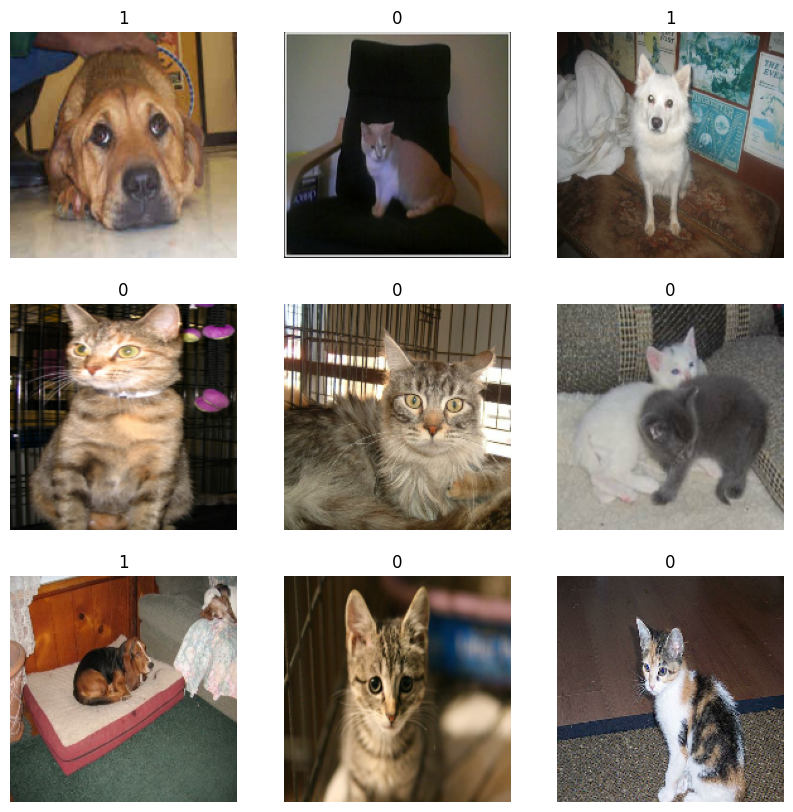

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

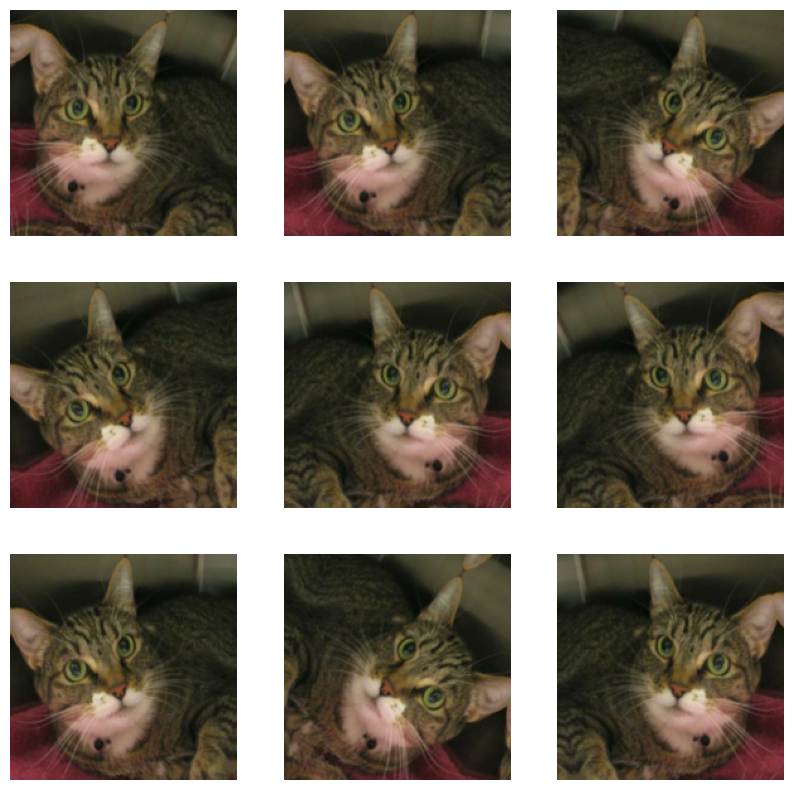

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(1, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [4, 8, 16]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(16, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save/save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 17s 86ms/step - loss: 0.6832 - accuracy: 0.5841 - val_loss: 0.7596 - val_accuracy: 0.4957
Epoch 2/25
147/147 [==============================] - 13s 85ms/step - loss: 0.6603 - accuracy: 0.6100 - val_loss: 0.7704 - val_accuracy: 0.4994
Epoch 3/25
147/147 [==============================] - 13s 85ms/step - loss: 0.6482 - accuracy: 0.6210 - val_loss: 0.6349 - val_accuracy: 0.6460
Epoch 4/25
147/147 [==============================] - 13s 84ms/step - loss: 0.6382 - accuracy: 0.6349 - val_loss: 0.6665 - val_accuracy: 0.5907
Epoch 5/25
147/147 [==============================] - 13s 85ms/step - loss: 0.6298 - accuracy: 0.6507 - val_loss: 0.6201 - val_accuracy: 0.6631
Epoch 6/25
147/147 [==============================] - 13s 85ms/step - loss: 0.6222 - accuracy: 0.6546 - val_loss: 0.6292 - val_accuracy: 0.6482
Epoch 7/25
147/147 [==============================] - 13s 86ms/step - loss: 0.6161 - accuracy: 0.6678 - val_loss: 0.5842 - val_accuracy:

1/1 [==============================] - 0s 13ms/step
This image is 52.46% cat and 47.54% dog.


C:\Users\zhang\AppData\Local\Temp\ipykernel_21168\2417345306.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


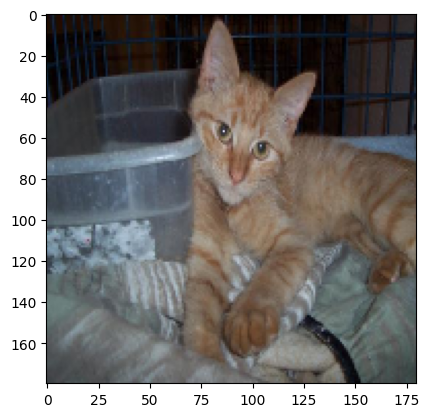

In [13]:
img = keras.utils.load_img(
    "PetImages/Cat/6777.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")